# A Primer on Explainability for GNNs

**Author**: [Alessio Devoto](https://alessiodevoto.github.io/)

This is an introductory tutorial to Explainable AI methods for Graph Neural Networks. It shows an application of [GNNExplainer](https://arxiv.org/abs/1903.03894) and some experiments with [Captum](https://captum.ai/). The notebook is inspired by [Simone Scardapane](https://sscardapane.it/)'s material on GNNs.




## 1. 🚗 Setup the colab environment

In [ ]:
%%capture
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install pytorch-lightning captum --quiet

In [ ]:
# GPU support
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install torch_geometric
# !pip install pytorch-lightning captum --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 44.3 MB/s eta 0:00:00


In [ ]:
# PyTorch imports
import torch
from torch.nn import functional as F

In [ ]:
# PyTorch-related imports
import torch_geometric as ptgeom
import torch_scatter, torch_sparse
import pytorch_lightning as ptlight
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

In [ ]:
# Other imports
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

In [ ]:
# PyG explainability
from torch_geometric.explain import Explainer, GNNExplainer
# Captum
from captum.attr import IntegratedGradients
from captum.influence import TracInCP, TracInCPFast

In [ ]:
matplotlib.rcParams['figure.dpi'] = 120 # I like higher resolution plots :)

In [ ]:
# We use the usual function for plotting molecules.

# This one is copy-pasted from: https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
from matplotlib.pyplot import figure

# transform the pytorch geometric graph into networkx format
def to_molecule(data: ptgeom.data.Data) -> nx.classes.digraph.DiGraph:
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

# plot the molecule
def draw_molecule(g, edge_mask=None, draw_edge_labels=True, draw_node_labels=True, ax=None, figsize=None):
    figure(figsize = figsize or (4, 3))

    # check if it's been already converted to a nx graph
    if not isinstance(g, nx.classes.digraph.DiGraph):
      g = to_molecule(g)

    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels if draw_node_labels else None, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', ax=ax)

    if ax is None:
      plt.show()


## 2. ⏩ Download Data & Train (we did this yesterday already)



In order to explain a model, we first need ... a model 😀.

We are going to train the same model as yesterday and store checkpoints in colab.

***Simply run all the cells in this section to train the model we will use for our explainers.***


In [ ]:
# Dataset
mutag = ptgeom.datasets.TUDataset(root='.', name='Mutagenicity')

# First, we split the original dataset into a training and test spart with a stratified split on the class
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25, random_state=11)
mutag_train = mutag[train_idx]
mutag_test = mutag[test_idx]


# Build the two loaders
train_loader = ptgeom.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = ptgeom.loader.DataLoader(mutag[test_idx], batch_size=32)

In [ ]:
# Define the Pytorch Lightning model

train_losses = []
eval_accs = []

class MUTAGClassifier(ptlight.LightningModule):

  def __init__(self, hidden_features: int):
    super().__init__()
    self.gc1 = ptgeom.nn.GCNConv(mutag.num_features, hidden_features)
    self.gc2 = ptgeom.nn.GCNConv(hidden_features, hidden_features)      # two "hops" seems enough for these small graphs
    self.gc3 = ptgeom.nn.GCNConv(hidden_features, hidden_features)
    self.gc4 = ptgeom.nn.GCNConv(hidden_features, hidden_features)
    self.pre_head = torch.nn.Linear(hidden_features, hidden_features)
    self.head = torch.nn.Linear(hidden_features, 1)                     # binary classification

  def forward(self, x, edge_index=None, batch=None, edge_weight=None):

    # unwrap the graph if the whole graph was passed
    if edge_index is None:
      x, edge_index, batch = x.x, x.edge_index, x.batch

    # GNN layers
    x = self.gc1(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc2(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc3(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc4(x, edge_index, edge_weight)
    x = F.relu(x)

    x = ptgeom.nn.global_mean_pool(x, batch) # now it's batch_size x embedding_dim
    x = F.dropout(x, p=0.5)
    x = self.pre_head(x)
    logits = self.head(x)

    return logits

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer


  def training_step(self, batch, _):

      logits = self.forward(batch.x, batch.edge_index, batch.batch)
      target = batch.y.unsqueeze(1)
      loss = F.binary_cross_entropy_with_logits(logits, target.float())

      self.log("train_loss", loss)
      self.log("train_accuracy", accuracy(logits, target, task='binary'), prog_bar=True, batch_size=32)
      train_losses.append(loss.detach())
      return loss

  def validation_step(self, batch, _):

    logits = self.forward(batch.x, batch.edge_index, batch.batch)
    target = batch.y.unsqueeze(1)
    loss = F.binary_cross_entropy_with_logits(logits, target.float())

    self.log("eval_accuracy", accuracy(logits, target, task='binary'), prog_bar=True, batch_size=32)
    eval_accs.append(accuracy(logits, target, task='binary'))

model = MUTAGClassifier(hidden_features=256)

In [ ]:
# We save checkpoints every 50 epochs
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-v2-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1)

In [ ]:
# Trainer and logs
trainer = ptlight.Trainer(max_epochs=100, callbacks=[checkpoint_callback])

# Train
trainer.fit(model, train_loader, test_loader)

In [ ]:
plt.plot([x.detach().item() for x in train_losses])
plt.plot([x.detach().item() for x in eval_accs])

## 3. 🤷 Explainability

Awesome! Now we have a model to explain.

The zoo of explainability techniques for Neural Networks is quite crowded.

Before we go on, it is crucial to underline that 'interpretability' is an umbrella term that we use to refer to any method that tries to explain an ML model. Unfortunately, there is not an agreed and shared taxonomy for such methods.

The meaning of *explanation* is not universal and depends on the chosen method and on what we are trying to explain.

Are we trying to interpret how much a single example is influential for the training? Are we trying to explain how much each input feature affects the the prediction?

For an intro to Interpretability, see [this paper](https://arxiv.org/pdf/1606.03490.pdf) or [this book](https://christophm.github.io/interpretable-ml-book/taxonomy-of-interpretability-methods.html).

![](https://blog.paperspace.com/content/images/2022/02/recommender.png)


Let's go!

### 3.1 GNNExplainer

GNNExplainer is a simple method to search for instance-level explanations on a trained GNN. It optimizes for the smallest feature and edge masks that do not vary the prediction of the trained model.

See the full explanation in the original paper: https://arxiv.org/pdf/1903.03894.pdf

As GNNExplainer is an instance-level method, let us first pick a graph and the corresponding prediction.

In [ ]:
# we pick a graph from the mutagenic ones
test_mutagenic = [mutag[test_idx[idx]] for idx in range(len(test_idx)) if mutag[test_idx[idx]].y.item() == 0]

In [ ]:
test_graph = test_mutagenic[0]
print(test_graph)

Data(edge_index=[2, 54], x=[25, 14], edge_attr=[54, 3], y=[1])


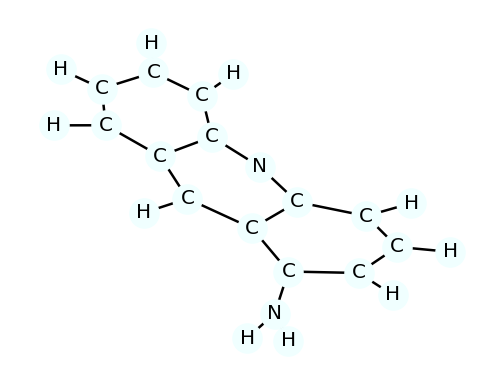

In [ ]:
# we want to explain this graph
draw_molecule(test_graph)

In [ ]:
# Define the Explainer here
# See full API here https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html

explainer = Explainer(
    algorithm=GNNExplainer(epochs=100),
    model = model,
    explanation_type = 'model',
    node_mask_type = 'object',
    edge_mask_type = 'object',
    model_config = dict(
        mode = 'binary_classification',
        task_level = 'graph',
        return_type = 'raw'
    )
  )

In [ ]:
# Get the explanation
explanation = explainer(x = test_graph.x, edge_index = test_graph.edge_index)

In [ ]:
# Explanation is just a mask on the edges and nodes. Here we care mostly about the edges
explanation

Explanation(node_mask=[25, 1], edge_mask=[54], prediction=[1, 1], target=[1], x=[25, 14], edge_index=[2, 54])

In [ ]:
mask = explanation.edge_mask
mask

tensor([0.2967, 0.3501, 0.2285, 0.3277, 0.3080, 0.1651, 0.3229, 0.3075, 0.7840,
        0.3149, 0.2672, 0.7319, 0.2743, 0.2123, 0.2487, 0.2778, 0.7370, 0.3679,
        0.2395, 0.4456, 0.8301, 0.3236, 0.6897, 0.2810, 0.2489, 0.2996, 0.2270,
        0.1873, 0.2042, 0.1772, 0.8115, 0.7996, 0.2669, 0.1992, 0.7623, 0.1915,
        0.1896, 0.5892, 0.2337, 0.8589, 0.6726, 0.7809, 0.7837, 0.7068, 0.7564,
        0.6068, 0.5965, 0.3457, 0.2952, 0.7756, 0.7518, 0.7063, 0.6578, 0.8203])

In [ ]:
# Get the highest values for each edge
mask.topk(k=10)

torch.return_types.topk(
values=tensor([0.8589, 0.8301, 0.8203, 0.8115, 0.7996, 0.7840, 0.7837, 0.7809, 0.7756,
        0.7623]),
indices=tensor([39, 20, 53, 30, 31,  8, 42, 41, 49, 34]))

In [ ]:
# Create a subgraph from non masked edges
subgraph = ptgeom.data.Data(x=test_graph.x, edge_index = test_graph.edge_index[:, mask > 0.8])

In [ ]:
# And remove isolated nodes
subgraph = ptgeom.transforms.RemoveIsolatedNodes()(subgraph)

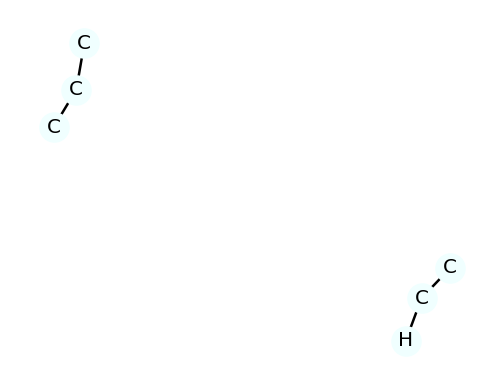

In [ ]:
# Plot the explanation
draw_molecule(subgraph)

### 3.2 💪 Exercise: Saliency for GNNs

Can we build a ***home made*** explainer, by just looking at the gradients that flow through the model ?

Many  attribution methods leverage the magnitude of the gradients with respect to input features, in order to estimate how important those features are for the output.
This is the case of saliency maps in Computer Vision.


![](https://www.kitware.com/main/wp-content/uploads/2021/12/Kitware_SailencyImageClassification-1.png)

**Can we do the same for graphs ?**


**Exercise:** Build a Saliency Map for `test_graph`.

Hint:
1. Get the prediction for the `test_graph`
2. Compute the gradient wrt the nodes.
3. Create a subgraph by filtering out the nodes which have a small gradient (you decide what 'small' means)
4. The subgraph will be our explanation!

In [ ]:
test_graph

Data(edge_index=[2, 54], x=[25, 14], edge_attr=[54, 3], y=[1])

In [ ]:
# Compute prediction
out = model(x=test_graph.x.requires_grad_(True), edge_index = test_graph.edge_index)

In [ ]:
# Compute gradients
out.backward()

In [ ]:
# Get the gradients for the nodes
# Notice that the shape of the gradients will be same as that of node features, so you need
# rearrange in a nice way
gradients = test_graph.x.grad.abs().sum(1)
gradients

tensor([7.7565, 7.9150, 6.5024, 6.3405, 8.1241, 5.2862, 6.8644, 5.2677, 7.4902,
        7.6525, 5.1373, 4.6357, 4.3730, 3.9524, 3.8697, 3.1498, 3.3158, 3.4395,
        5.6700, 5.6700, 3.2765, 3.1053, 2.9377, 2.4069, 2.3446])

In [ ]:
# Select topk nodes with highest value
# Hint: use torch.topk() method
vals, idcs = gradients.topk(k=6)

In [ ]:
# Create a new subgraph from the topk nodes
# Hint: https://pytorch-geometric.readthedocs.io/en/2.0.3/modules/utils.html#torch_geometric.utils.subgraph
new_edge_indx, _ = ptgeom.utils.subgraph(subset=idcs, edge_index=test_graph.edge_index, relabel_nodes=True)
new_edge_indx

tensor([[2, 1, 1, 0, 0, 5, 3, 3],
        [1, 2, 0, 1, 3, 3, 0, 5]])

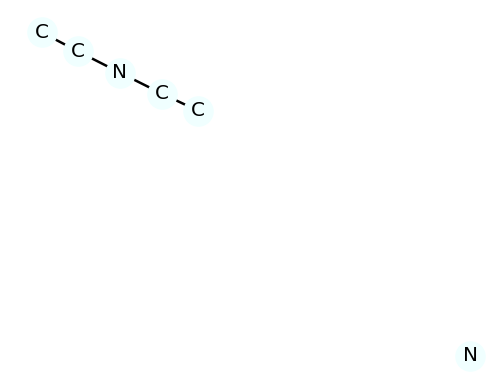

In [ ]:
# Draw the explanation
expl = ptgeom.data.Data(x=test_graph.x[idcs], edge_index=new_edge_indx)
draw_molecule(expl)

### 3.2 Integrated gradients

[Integrated gradients](https://arxiv.org/abs/1703.01365) is a model-agnostic instance-level interpretability method.

The [idea](https://medium.com/@kemalpiro/xai-methods-integrated-gradients-6ee1fe4120d8) of Integrated Gradients is to integrate a "saliency vector" moving from a graph with no connectivity to our actual graph. As we interpolate from the initial empty graph to our test graph, we will observe the gradient with respect to some of the features changes more, meaning those features are more important for the classification.

![](https://captum.ai/img/IG_eq1.png)

We will use [Captum](https://captum.ai/), a library which offers a rich toolset of explainable AI methods.

In [ ]:
test_graph

Data(edge_index=[2, 54], x=[25, 14], edge_attr=[54, 3], y=[1])

In [ ]:
batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64) # All nodes belong to the same graph

# Initialize the edge mask
edge_mask = torch.ones(test_graph.edge_index.shape[1]).unsqueeze(0).requires_grad_(True)
baseline = torch.zeros_like(edge_mask)



In [ ]:
# We just define a custom function whose input is the edge mask

model.eval()
def model_forward(edge_mask):
    out = model(test_graph.x, test_graph.edge_index, batch_idx, edge_weight=edge_mask[0])
    return out

In [ ]:
# Define integrated gradients https://captum.ai/api/integrated_gradients.html
ig = IntegratedGradients(model_forward)

In [ ]:
# Compute attribution
mask = ig.attribute(edge_mask, n_steps=100, internal_batch_size=1)

In [ ]:
# This is identical to before, using the new mask
explanation = ptgeom.data.Data(test_graph.x, test_graph.edge_index[:, mask[0] > 0.1])
explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))
explanation

Data(x=[25, 14], edge_index=[2, 38])

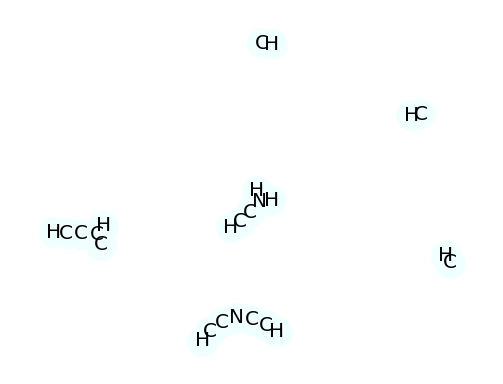

In [ ]:
draw_molecule(explanation)

### 3.3 TracIn

[TracIn](https://arxiv.org/pdf/2002.08484.pdf) is an explanbility method which computes the influence of training examples on the prediction of test examples.

As you probably noticed, the goal of TracIn is quite different from the one of the other intepretability methods we saw so far.

The main idea behind TracIn is to compute how much the prediction accuracy for a test graph changes when we train the model on a specific train graph.

In [ ]:
# We are going to need those checkpoints
!ls checkpoints

'gnn-epoch=49.ckpt'	'gnn-epoch=99.ckpt'	'gnn-v2-epoch=99.ckpt'
'gnn-epoch=49-v1.ckpt'	'gnn-epoch=99-v1.ckpt'
'gnn-epoch=49-v2.ckpt'	'gnn-v2-epoch=49.ckpt'


In [ ]:
checkpoints = ['checkpoints/gnn-v2-epoch=49.ckpt' , 'checkpoints/gnn-v2-epoch=99.ckpt']

In [ ]:
# We only compute the gradients for the last layer parameters
params_shape = model.head.weight.shape[1]
params_shape

256

In [ ]:
# We will store the gradients here

test_grads = torch.zeros(len(checkpoints), params_shape)
train_grads = torch.zeros(len(train_idx), len(checkpoints), params_shape)

In [ ]:
# Compute gradient at checkpints for test sample

for i in range(len(checkpoints)):

  # Load checkpoint
  ckpt = torch.load(checkpoints[i])
  model.load_state_dict(ckpt['state_dict'])
  model.eval()

  # Compute gradients
  out = model(test_graph)
  grad = torch.autograd.grad(out, model.head.weight)[0]


  test_grads[i] = grad

In [ ]:
# Compute gradient at checkpoints for train samples

for i in range(len(checkpoints)):

  # Load checkpoint
  ckpt = torch.load(checkpoints[i])
  model.load_state_dict(ckpt['state_dict'])
  model.eval()

  # Compute gradients for each graph
  for sample in range(len(train_idx)):

    out = model(mutag_train[i].x, mutag_train[i].edge_index)
    grad = torch.autograd.grad(out, model.head.weight)[0]

    train_grads[sample][i] = grad

In [ ]:
# Compute TracIn scores

# test_grads  ( , 2, 256)
# train_grads (n, 2, 256 )

relevance = (train_grads * test_grads).sum([1,2])

In [ ]:
# Which training graphs were the most influential ?

_, proponents_indices = relevance.topk(k=3, largest=True)
_, opponents_indices = relevance.topk(k=3, largest=False)

Label: 0


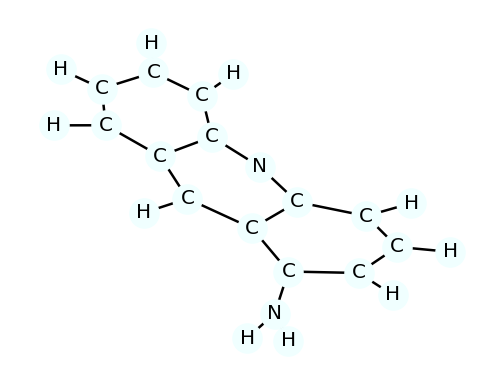

In [ ]:
print('Label:', test_graph.y.item())
draw_molecule(test_graph)

tensor(857)
Label: 1


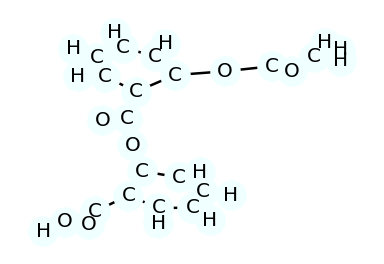

tensor(2737)
Label: 1


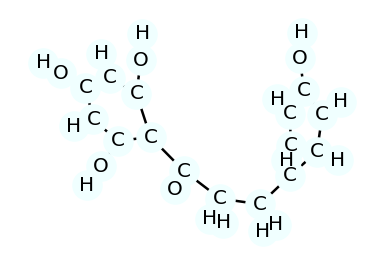

tensor(681)
Label: 1


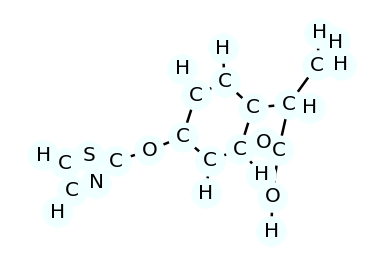

In [ ]:
for p in proponents_indices:
  print(p)
  print('Label:', mutag_train[p].y.item())
  draw_molecule(mutag_train[p], figsize=(3,2))

Label: 0


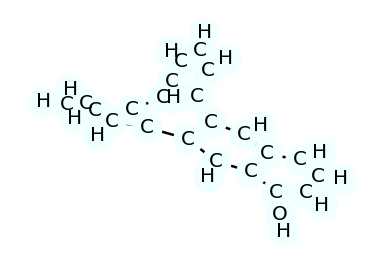

Label: 1


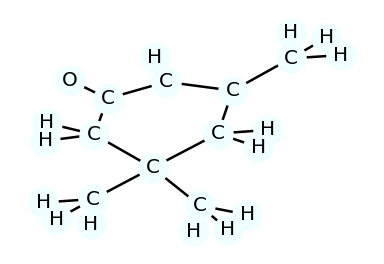

Label: 1


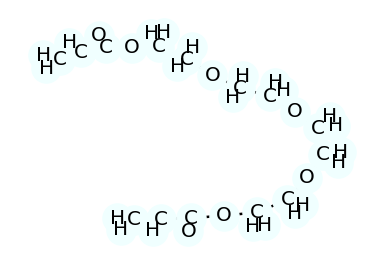

In [ ]:
for o in opponents_indices:
  print('Label:', mutag_train[o].y.item())
  draw_molecule(mutag_train[o], figsize=(3,2))